In [1]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from matplotlib import rc
from matplotlib.font_manager import fontManager
from pathlib import Path
from fd_analysis.prepare import filter_corrupt_files, get_python_projects_df, get_python_projects, get_depsfiles
from collections import defaultdict

%matplotlib inline

In [2]:
font_path = "/usr/local/share/fonts/Virgil.ttf"

# Register the font
fontManager.addfont(font_path)
font = {"family": "Virgil 3 YOFF"}

# Import data


In [3]:
paths_biomed = "../data/results_biomed_20240423/"

data_biomed, corrupt_biomed = filter_corrupt_files(
    [Path(paths_biomed) / file for file in os.listdir(paths_biomed)]
)

print("Corrupt: ", corrupt_biomed)
len(data_biomed)

Corrupt:  []


1818

In [4]:
paths_pypi = "../data/results_pypi_20240423/"

data_pypi, corrupt_pypi = filter_corrupt_files(
    [Path(paths_pypi) / file for file in os.listdir(paths_pypi)]
)

print("Corrupt: ", corrupt_pypi)
len(data_pypi)

Corrupt:  []


1160

In [5]:
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-04-23T15:56:58.527634'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

# Code structure


In [6]:
df_codedirs_biomed = get_python_projects_df(data_biomed)
python_projects_biomed = get_python_projects(df_codedirs_biomed)

In [7]:
df_codedirs_pypi = get_python_projects_df(data_pypi)
python_projects_pypi = get_python_projects(df_codedirs_pypi)

In [8]:
len(python_projects_biomed), len(python_projects_pypi)

(1260, 1118)

In [9]:
df_codedirs_biomed.head(), df_codedirs_pypi.head()

(           darkflow/dark       darkflow/utils       darkflow/net        \
                       py ipynb             py ipynb           py ipynb   
 darkflow             6.0   0.0            6.0   0.0          5.0   0.0   
 encode2bag           NaN   NaN            NaN   NaN          NaN   NaN   
 osmosis              NaN   NaN            NaN   NaN          NaN   NaN   
 brian2genn           NaN   NaN            NaN   NaN          NaN   NaN   
 yeadon               NaN   NaN            NaN   NaN          NaN   NaN   
 
            darkflow/net/yolo       darkflow/net/yolov2        ...  \
                           py ipynb                  py ipynb  ...   
 darkflow                 5.0   0.0                 4.0   0.0  ...   
 encode2bag               NaN   NaN                 NaN   NaN  ...   
 osmosis                  NaN   NaN                 NaN   NaN  ...   
 brian2genn               NaN   NaN                 NaN   NaN  ...   
 yeadon                   NaN   NaN                 N

In [10]:
codedirs_py_biomed = df_codedirs_biomed.xs("py", level=1, axis=1)
codedirs_ipynb_biomed = df_codedirs_biomed.xs("ipynb", level=1, axis=1)
codedirs_sum_biomed = codedirs_py_biomed + codedirs_ipynb_biomed

codedirs_py_pypi = df_codedirs_pypi.xs("py", level=1, axis=1)
codedirs_ipynb_pypi = df_codedirs_pypi.xs("ipynb", level=1, axis=1)
codedirs_sum_pypi = codedirs_py_pypi + codedirs_ipynb_pypi

In [11]:
drop_cols_biomed = [
    col
    for col in codedirs_sum_biomed.columns
    if "test" in col.lower()
    or "example" in col.lower()
    or "sample" in col.lower()
    or "doc" in col.lower()
    or "tutorial" in col.lower()
]

drop_cols_pypi = [
    col
    for col in codedirs_sum_pypi.columns
    if "test" in col.lower()
    or "example" in col.lower()
    or "sample" in col.lower()
    or "doc" in col.lower()
    or "tutorial" in col.lower()
]

In [12]:
codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns=drop_cols_biomed).idxmax(
    axis=1
)
codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns=drop_cols_pypi).idxmax(axis=1)

/tmp/ipykernel_153979/4160416966.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns=drop_cols_biomed).idxmax(
/tmp/ipykernel_153979/4160416966.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns=drop_cols_pypi).idxmax(axis=1)


In [13]:
codedirs_sum_main_biomed, codedirs_sum_main_pypi

(darkflow                  darkflow/dark
 encode2bag                 PROJECT_NAME
 osmosis                   osmosis/ipynb
 brian2genn                 PROJECT_NAME
 yeadon                     PROJECT_NAME
                         ...            
 diffusion                           NaN
 nextmed               src visualization
 ReproPhylo                 Galaxy_tools
 x2k_web       src/main/webapp/notebooks
 deep-rules               content/images
 Length: 1260, dtype: object,
 jupyter_ydoc                                                       PROJECT_NAME
 jira                                                               PROJECT_NAME
 rasterio                                                           PROJECT_NAME
 pygit2                                                             PROJECT_NAME
 Box                                                                PROJECT_NAME
                                                     ...                        
 ApplicationInsights-Python    az

In [14]:
same_name_projects_biomed = set(
    [k for k, v in codedirs_sum_main_biomed.items() if v == "PROJECT_NAME"]
)
src_projects_biomed = set(
    [
        k
        for k, v in codedirs_sum_main_biomed.items()
        if not v != v and v.startswith("src")
    ]
)
root_dir_projects_biomed = set(
    [k for k, v in codedirs_sum_main_biomed.items() if v == "."]
)
rest_projects_biomed = (
    python_projects_biomed
    - same_name_projects_biomed
    - src_projects_biomed
    - root_dir_projects_biomed
)

same_name_projects_pypi = set(
    [k for k, v in codedirs_sum_main_pypi.items() if v == "PROJECT_NAME"]
)
src_projects_pypi = set(
    [k for k, v in codedirs_sum_main_pypi.items() if not v != v and v.startswith("src")]
)
root_dir_projects_pypi = set([k for k, v in codedirs_sum_main_pypi.items() if v == "."])
rest_projects_pypi = (
    python_projects_pypi
    - same_name_projects_pypi
    - src_projects_pypi
    - root_dir_projects_pypi
)

In [15]:
plot_data_biomed = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_biomed),
            len(src_projects_biomed),
            len(rest_projects_biomed),
            len(root_dir_projects_biomed),
        ],
        "Percentage": [0.25, 0.25, 0.25, 0.25],
    }
)
plot_data_pypi = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_pypi),
            len(src_projects_pypi),
            len(rest_projects_pypi),
            len(root_dir_projects_pypi),
        ],
        "Percentage": [0.25, 0.25, 0.25, 0.25],
    }
)

plot_data_biomed["Group"] = "biomedical packages"
plot_data_pypi["Group"] = "PyPI packages"

plot_data = pd.concat([plot_data_biomed, plot_data_pypi])
grouped_data = plot_data.groupby(["Group", "Category"]).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(index="Category", columns="Group", values="Counts")


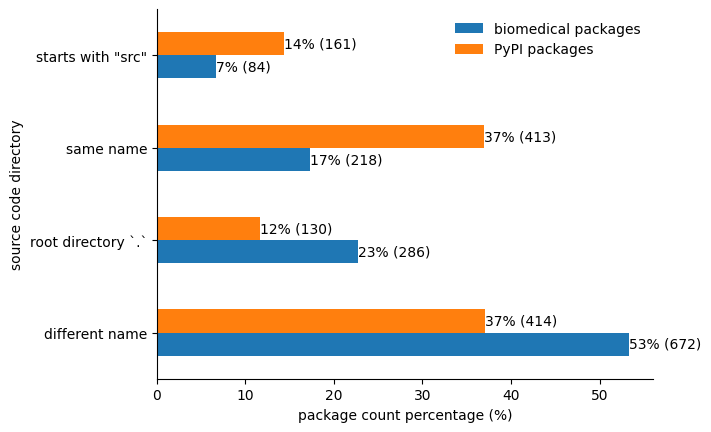

In [17]:
# Assuming pivot_table contains your data, normalize it for percentage values
pivot_table_percent = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percent = pivot_table_percent.iloc[:, ::-1]

# Plotting the data as percentages
ax = pivot_table_percent.plot(kind="barh")

# Labels and title
plt.xlabel("package count percentage (%)")
plt.ylabel("source code directory")

# Add legend
plt.legend(frameon=False)

# Remove top and right border (spines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_yticklabels([label.get_text().lower() for label in ax.get_yticklabels()])

# Annotate each bar with absolute values and display percentages on the axis
for p in ax.patches:
    width = p.get_width()  # This gives the percentage value
    height = p.get_height()
    x, y = p.get_xy()

    # Find the corresponding absolute value
    index = ax.patches.index(p)
    if index < 4:
        absolute_value = pivot_table.iloc[index]["biomedical packages"]
    else:
        absolute_value = pivot_table.iloc[index - 4]["PyPI packages"]

    # Annotate with absolute value and percentage
    ax.annotate(
        f"{width:.0f}% ({absolute_value})",
        (x + width, y + height / 2),
        va="center",
    )
plt.savefig("code_structure.png", dpi=600, bbox_inches="tight")
plt.show()

# Dependency declarations


In [17]:
depsfiles_biomed = get_depsfiles(data_biomed)
depsfiles_pypi = get_depsfiles(data_pypi)

732
1117


In [18]:
project_with_deps_biomed = set()
for project_name, depsfile in depsfiles_biomed.items():
    for dep in depsfile:
        if dep["parser_choice"] == "requirements.txt" or dep["deps_count"] > 0:
            project_with_deps_biomed.add(project_name)
            break

project_with_deps_pypi = set()
for project_name, depsfile in depsfiles_pypi.items():
    for dep in depsfile:
        if dep["parser_choice"] == "requirements.txt" or dep["deps_count"] > 0:
            project_with_deps_pypi.add(project_name)
            break

In [19]:
def autopct_format(values, hidden_values=[]):
    def my_format(pct, hidden_values=hidden_values):
        if round(pct, 3) in hidden_values:
            return ""
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val) if pct > 0 else ""

    return my_format

In [20]:
dep_counts_biomed = np.array(
    [len(depsfiles_biomed), len(python_projects_biomed) - len(depsfiles_biomed)]
)
dep_counts_pypi = np.array(
    [len(depsfiles_pypi), len(python_projects_pypi) - len(depsfiles_pypi)]
)

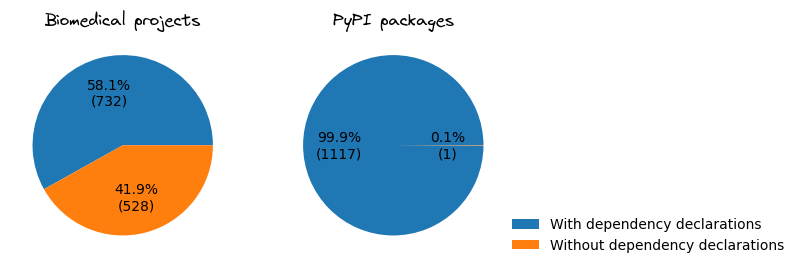

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(dep_counts_biomed, autopct=autopct_format(dep_counts_biomed))
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(dep_counts_pypi, autopct=autopct_format(dep_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(
    loc=(1, 0),
    labels=["With dependency declarations", "Without dependency declarations"],
    frameon=False,
)
plt.subplots_adjust(top=1)
plt.savefig("distribution_deps_1.png", dpi=600, bbox_inches="tight")

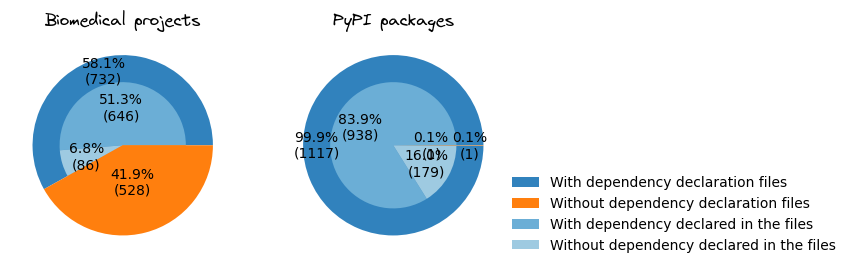

In [50]:
dep_counts_biomed_nested = np.array(
    [
        [
            len(project_with_deps_biomed),
            len(depsfiles_biomed) - len(project_with_deps_biomed),
        ],
        [len(python_projects_biomed) - len(depsfiles_biomed), 0],
    ]
)
dep_counts_pypi_nested = np.array(
    [
        [
            len(project_with_deps_pypi),
            len(depsfiles_pypi) - len(project_with_deps_pypi),
        ],
        [len(python_projects_pypi) - len(depsfiles_pypi), 0],
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2)

size = 0.3
cmap = plt.colormaps["tab20c"]
cmap2 = plt.colormaps["tab10"]
outer_colors = [cmap(0), cmap2(1)]
inner_colors = [cmap(1), cmap(2), cmap2(1), cmap(1)]

ax1.pie(
    dep_counts_biomed_nested.sum(axis=1),
    radius=1,
    colors=outer_colors,
    autopct=autopct_format(dep_counts_biomed_nested.sum(axis=1), hidden_values=[round(dep_counts_biomed_nested.sum(axis=1)[1]/dep_counts_biomed_nested.sum(axis=1).sum()*100, 3)]),
    pctdistance=0.85,
)

ax1.pie(
    dep_counts_biomed_nested.flatten(),
    radius=1 - size,
    colors=inner_colors,
    autopct=autopct_format(dep_counts_biomed_nested.flatten()),
    pctdistance=0.6,
)


ax2.pie(
    dep_counts_pypi_nested.sum(axis=1),
    radius=1,
    colors=outer_colors,
    autopct=autopct_format(dep_counts_pypi_nested.sum(axis=1)),
    pctdistance=0.85,
)

ax2.pie(
    dep_counts_pypi_nested.flatten(),
    radius=1 - size,
    colors=inner_colors,
    autopct=autopct_format(dep_counts_pypi_nested.flatten()),
    pctdistance=0.6,
)

plt.legend(
    loc=(1, 0),
    labels=[
        "With dependency declaration files",
        "Without dependency declaration files",
        "With dependency declared in the files",
        "Without dependency declared in the files",
    ],
    frameon=False,
)
plt.subplots_adjust(top=1)
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)

plt.savefig("distribution_deps_1_new.png", dpi=600, bbox_inches="tight")
plt.show()

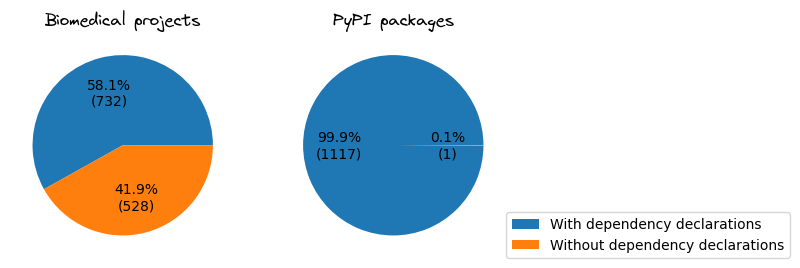

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(dep_counts_biomed, autopct=autopct_format(dep_counts_biomed))
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(dep_counts_pypi, autopct=autopct_format(dep_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(
    loc=(1, 0),
    labels=["With dependency declarations", "Without dependency declarations"],
)
plt.subplots_adjust(top=1)
plt.savefig("distribution_deps_1.png", dpi=600, bbox_inches="tight")

In [21]:
project_req_txt_biomed = set()
project_pyproject_toml_biomed = set()
project_setup_biomed = set()

for project_name, deps in depsfiles_biomed.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt_biomed.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml" and dep["deps_count"] > 0:
            project_pyproject_toml_biomed.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup_biomed.add(project_name)
            break

In [22]:
project_req_txt_pypi = set()
project_pyproject_toml_pypi = set()
project_setup_pypi = set()

for project_name, deps in depsfiles_pypi.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml" and dep["deps_count"] > 0:
            project_pyproject_toml_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup_pypi.add(project_name)
            break

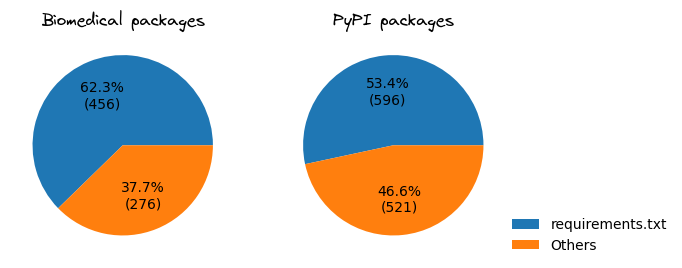

In [51]:
req_txt_counts_biomed = np.array(
    [len(project_req_txt_biomed), len(depsfiles_biomed) - len(project_req_txt_biomed)]
)
req_txt_counts_pypi = np.array(
    [len(project_req_txt_pypi), len(depsfiles_pypi) - len(project_req_txt_pypi)]
)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(req_txt_counts_biomed, autopct=autopct_format(req_txt_counts_biomed))
ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(req_txt_counts_pypi, autopct=autopct_format(req_txt_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["requirements.txt", "Others"], frameon=False)
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.1.png", dpi=600, bbox_inches="tight")

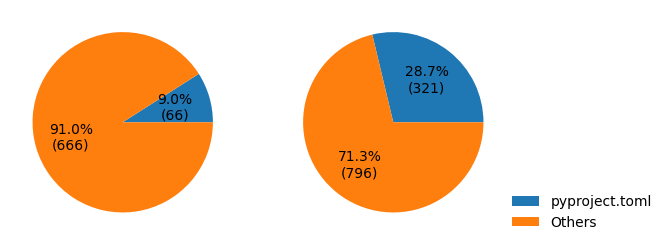

In [51]:
pyproject_toml_counts_biomed = np.array(
    [len(project_pyproject_toml_biomed), len(depsfiles_biomed) - len(project_pyproject_toml_biomed)]
)
pyproject_toml_counts_pypi = np.array(
    [
        len(project_pyproject_toml_pypi),
        len(depsfiles_pypi) - len(project_pyproject_toml_pypi),
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(pyproject_toml_counts_biomed, autopct=autopct_format(pyproject_toml_counts_biomed))
# ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(pyproject_toml_counts_pypi, autopct=autopct_format(pyproject_toml_counts_pypi))
# ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["pyproject.toml", "Others"], frameon=False)
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.2.png", dpi=600, bbox_inches="tight")

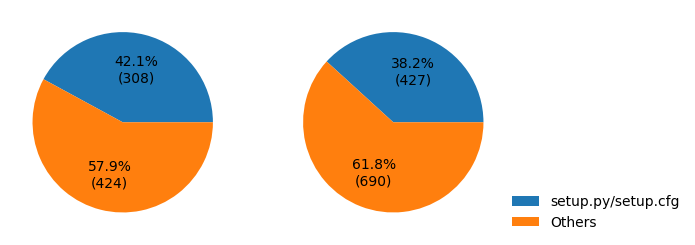

In [52]:
setup_counts_biomed = np.array(
    [len(project_setup_biomed), len(depsfiles_biomed) - len(project_setup_biomed)]
)
setup_counts_pypi = np.array(
    [len(project_setup_pypi), len(depsfiles_pypi) - len(project_setup_pypi)]
)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(setup_counts_biomed, autopct=autopct_format(setup_counts_biomed))
# ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(setup_counts_pypi, autopct=autopct_format(setup_counts_pypi))
# ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["setup.py/setup.cfg", "Others"], frameon=False)
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.3.png", dpi=600, bbox_inches="tight")

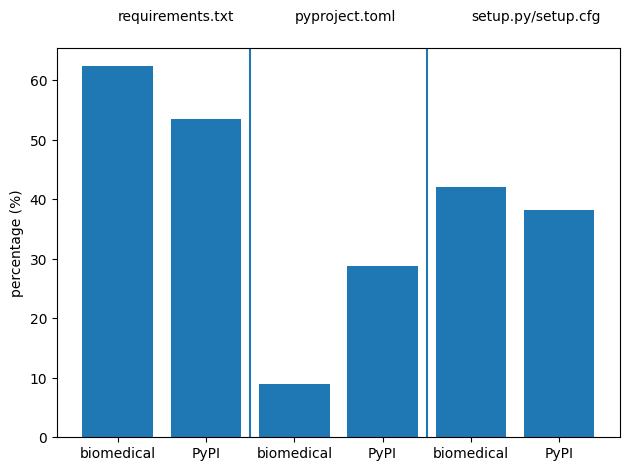

In [53]:

fig = plt.figure()
ax = fig.add_subplot()
xpos = list(range(6))
ax.bar(
    xpos,
    [
        62.3, 53.4,
        9.0, 28.7,
        42.1, 38.2
    ]
)
ax.set_xticks(xpos)
ax.set_xticklabels(
    (
        "biomedical", "PyPI",
        "biomedical", "PyPI",
        "biomedical", "PyPI"
    )
)
ax.set_ylabel("percentage (%)")
ax.axvline(1.5)
ax.axvline(3.5)
ax.text(*(0, 70), "requirements.txt")
ax.text(*(2, 70), "pyproject.toml")
ax.text(*(4, 70), "setup.py/setup.cfg")

fig.tight_layout()

plt.savefig("distribution_deps_2.png", dpi=600, bbox_inches="tight")
plt.show()

In [23]:
project_req_toml_setup_biomed = project_req_txt_biomed.intersection(
    project_pyproject_toml_biomed
).intersection(project_setup_biomed)
project_req_only_biomed = project_req_txt_biomed - project_pyproject_toml_biomed - project_setup_biomed
project_toml_only_biomed = project_pyproject_toml_biomed - project_req_txt_biomed - project_setup_biomed
project_setup_only_biomed = project_setup_biomed - project_req_txt_biomed - project_pyproject_toml_biomed
project_req_toml_biomed = project_req_txt_biomed.intersection(
    project_pyproject_toml_biomed
) - project_req_toml_setup_biomed
project_req_setup_biomed = project_req_txt_biomed.intersection(
    project_setup_biomed
) - project_req_toml_setup_biomed
project_toml_setup_biomed = project_pyproject_toml_biomed.intersection(
    project_setup_biomed
) - project_req_toml_setup_biomed
project_no_deps_biomed = python_projects_biomed - depsfiles_biomed.keys()

In [24]:
project_req_toml_setup_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
).intersection(project_setup_pypi)
project_req_only_pypi = (
    project_req_txt_pypi - project_pyproject_toml_pypi - project_setup_pypi
)
project_toml_only_pypi = (
    project_pyproject_toml_pypi - project_req_txt_pypi - project_setup_pypi
)
project_setup_only_pypi = (
    project_setup_pypi - project_req_txt_pypi - project_pyproject_toml_pypi
)
project_req_toml_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
) - project_req_toml_setup_pypi
project_req_setup_pypi = project_req_txt_pypi.intersection(
    project_setup_pypi
) - project_req_toml_setup_pypi
project_toml_setup_pypi = project_pyproject_toml_pypi.intersection(
    project_setup_pypi
) - project_req_toml_setup_pypi
project_no_deps_pypi = python_projects_pypi - depsfiles_pypi.keys()

In [25]:
df_deps_count_biomed = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only_biomed),
            len(project_toml_only_biomed),
            len(project_setup_only_biomed),
            len(project_req_toml_biomed),
            len(project_req_setup_biomed),
            len(project_toml_setup_biomed),
            len(project_req_toml_setup_biomed),
            len(python_projects_biomed) - len(project_with_deps_biomed),
        ],
    )
)

In [26]:
df_deps_count_pypi = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only_pypi),
            len(project_toml_only_pypi),
            len(project_setup_only_pypi),
            len(project_req_toml_pypi),
            len(project_req_setup_pypi),
            len(project_toml_setup_pypi),
            len(project_req_toml_setup_pypi),
            len(python_projects_pypi) - len(project_with_deps_pypi),
        ],
    )
)

In [27]:
desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]

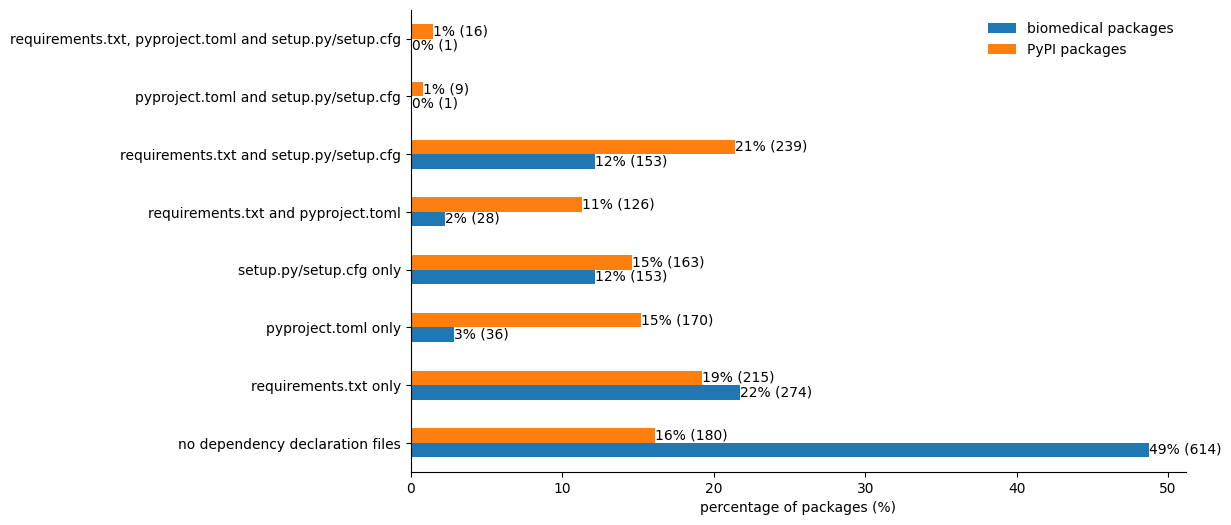

In [59]:
df_deps_count_biomed["Group"] = "biomedical packages"
df_deps_count_pypi["Group"] = "PyPI packages"
deps_count_combined = pd.concat([df_deps_count_biomed, df_deps_count_pypi])
grouped_data = deps_count_combined.groupby(["Group", "type_"]).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(
    index="type_", columns="Group", values="count"
).reindex(desired_order)

pivot_table_percent = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percent = pivot_table_percent.iloc[:, ::-1]

# Plotting
plt.rcParams["figure.figsize"] = [10, 6]
ax = pivot_table_percent.plot(kind="barh")

plt.xlabel("percentage of packages (%)")
plt.ylabel("")
# plt.title(
#     "Distribution of dependency declarations", fontname="Virgil 3 YOFF", fontsize=14
# )
plt.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()

    if ax.patches.index(p) < 8:
        absolute_value = pivot_table.iloc[ax.patches.index(p)]["biomedical packages"]
    else:
        absolute_value = pivot_table.iloc[ax.patches.index(p) - 8]["PyPI packages"]
    ax.annotate(
        f"{width:.0f}% ({absolute_value})",
        (x + width, y + height / 4),
    )
plt.savefig("distribution_deps_3.png", dpi=600, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

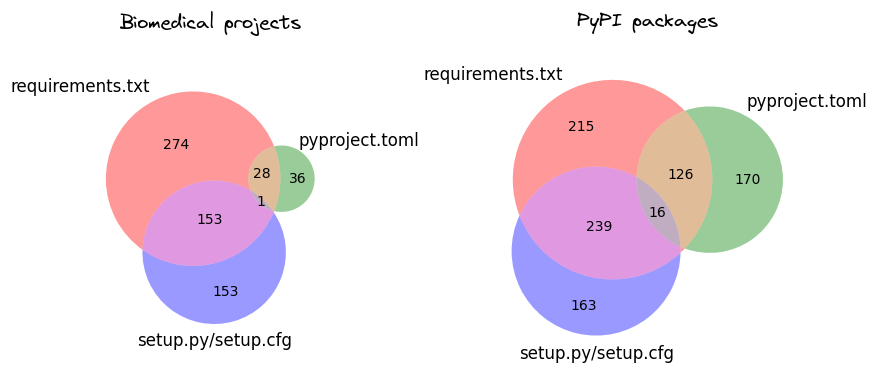

In [77]:
# Draw a venn diagram
plt.figure()

ratios = [645, 829]
norm = [n / sum(ratios) for n in ratios]

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=norm), figsize=[20 * n for n in norm])

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers_biomed = venn3(
    [project_req_txt_biomed, project_pyproject_toml_biomed, project_setup_biomed],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax1,
)

venn_parsers_pypi = venn3(
    [project_req_txt_pypi, project_pyproject_toml_pypi, project_setup_pypi],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax2,
)

ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=14, y=1.14)
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=14, y=1.08)

# plt.subplots_adjust(top=0.95)

fig.tight_layout() 
# plt.show()

plt.savefig("distribution_deps_4.png", dpi=600, bbox_inches="tight")

# Dependency declaration & code structure


In [109]:
conditions_biomed = [
    (codedirs_sum_main_biomed.index.isin(project_dep))
    for project_dep in [
        project_req_only_biomed,
        project_toml_only_biomed,
        project_setup_only_biomed,
        project_req_toml_biomed,
        project_req_setup_biomed,
        project_toml_setup_biomed,
        project_req_toml_setup_biomed,
        project_no_deps_biomed,
    ]
]
# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt \nand pyproject.toml",
    "requirements.txt \nand setup.py/setup.cfg",
    "pyproject.toml \nand setup.py/setup.cfg",
    "requirements.txt, pyproject.toml \nand setup.py/setup.cfg",
    "no dependency \ndeclaration files",
]

desired_order = [
    "no dependency \ndeclaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt \nand pyproject.toml",
    "requirements.txt \nand setup.py/setup.cfg",
    "pyproject.toml \nand setup.py/setup.cfg",
    "requirements.txt, pyproject.toml \nand setup.py/setup.cfg",
]

codedirs_sum_main_biomed = pd.DataFrame(codedirs_sum_main_biomed)
codedirs_sum_main_biomed["deps"] = np.select(conditions_biomed, values)
codedirs_sum_main_biomed["deps"] = pd.Categorical(
    codedirs_sum_main_biomed["deps"], categories=desired_order, ordered=True
)

In [110]:
conditions_pypi = [
    (codedirs_sum_main_pypi.index.isin(project_dep))
    for project_dep in [
        project_req_only_pypi,
        project_toml_only_pypi,
        project_setup_only_pypi,
        project_req_toml_pypi,
        project_req_setup_pypi,
        project_toml_setup_pypi,
        project_req_toml_setup_pypi,
        project_no_deps_pypi,
    ]
]
codedirs_sum_main_pypi = pd.DataFrame(codedirs_sum_main_pypi)
codedirs_sum_main_pypi["deps"] = np.select(conditions_pypi, values)
codedirs_sum_main_pypi["deps"] = pd.Categorical(
    codedirs_sum_main_pypi["deps"], categories=desired_order, ordered=True
)

In [111]:
codedirs_sum_main_biomed.head(), codedirs_sum_main_pypi.head()

(                        0                                       deps  count  \
 darkflow    darkflow/dark                      requirements.txt only    6.0   
 encode2bag   PROJECT_NAME                    setup.py/setup.cfg only    4.0   
 osmosis     osmosis/ipynb                                        NaN   60.0   
 brian2genn   PROJECT_NAME                        pyproject.toml only    8.0   
 yeadon       PROJECT_NAME  requirements.txt \nand setup.py/setup.cfg    9.0   
 
             .ipynb count  .ipynb>0  .ipynb>=5  .ipynb>=10  
 darkflow             0.0     False      False       False  
 encode2bag           0.0     False      False       False  
 osmosis             80.0      True       True        True  
 brian2genn           0.0     False      False       False  
 yeadon               1.0      True      False       False  ,
                          0                                       deps  count
 jupyter_ydoc  PROJECT_NAME                        pyproject.toml only   

In [112]:
codedirs_sum_biomed.head()

,darkflow/dark,darkflow/utils,darkflow/net,darkflow/net/yolo,darkflow/net/yolov2,darkflow/net/ops,PROJECT_NAME,darkflow/net/vanilla,test,darkflow/net/mnist,...,layer_runs2/n_message_6,layer_runs2/n_message_1,layer_runs2/n_message_7,layer_runs2/n_message_8,layer_runs2/n_message_9,layer_runs2/n_message_2,layer_runs2/n_message_4,layer_runs2/n_message_10,layer_runs2/n_message_3,20190909_figure4
darkflow,6.0,6.0,5.0,5.0,4.0,4.0,4.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
codedirs_sum_main_biomed["count"] = [
    (
        codedirs_sum_biomed.loc[idx][codedirs_sum_main_biomed[0].loc[idx]]
        if type(codedirs_sum_main_biomed[0].loc[idx]) == str
        else 0.0
    )
    for idx in codedirs_sum_biomed.index
]
codedirs_sum_main_pypi["count"] = [
    (
        codedirs_sum_pypi.loc[idx][codedirs_sum_main_pypi[0].loc[idx]]
        if type(codedirs_sum_main_pypi[0].loc[idx]) == str
        else 0.0
    )
    for idx in codedirs_sum_pypi.index
]

In [114]:
codedirs_ipynb_biomed.sum(axis=1)

darkflow       0.0
encode2bag     0.0
osmosis       80.0
brian2genn     0.0
yeadon         1.0
              ... 
diffusion      0.0
nextmed        0.0
ReproPhylo    19.0
x2k_web        1.0
deep-rules     1.0
Length: 1260, dtype: float64

In [115]:
codedirs_sum_main_biomed[".ipynb count"] = codedirs_ipynb_biomed.sum(axis=1)
codedirs_sum_main_biomed[".ipynb count"] = codedirs_sum_main_biomed[
    ".ipynb count"
].fillna(0)

In [116]:
codedirs_sum_main_biomed[".ipynb>0"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] > 0, True, False
)
codedirs_sum_main_biomed[".ipynb>=5"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 5, True, False
)
codedirs_sum_main_biomed[".ipynb>=10"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 10, True, False
)

In [117]:
filtered_data_biomed = codedirs_sum_main_biomed[codedirs_sum_main_biomed["count"] < 100]

# Define the values you want to remove from the 'deps' column
values_to_remove = ["pyproject.toml \nand setup.py/setup.cfg",
    "requirements.txt, pyproject.toml \nand setup.py/setup.cfg",]

# Remove rows where 'deps' contains those values
filtered_data_biomed = filtered_data_biomed[~filtered_data_biomed['deps'].isin(values_to_remove)]

In [118]:
desired_order_biomed = [
    "no dependency \ndeclaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt \nand pyproject.toml",
    "requirements.txt \nand setup.py/setup.cfg",
]

filtered_data_biomed["deps"] = pd.Categorical(
    filtered_data_biomed["deps"], categories=desired_order_biomed, ordered=True
)


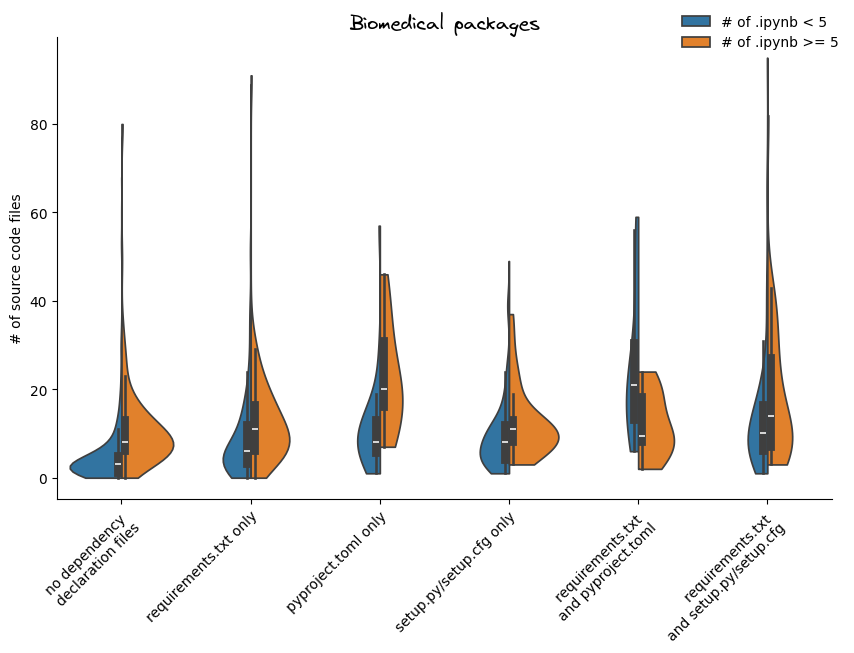

In [120]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=5",
    data=filtered_data_biomed,
    split=True,
    cut=0,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["# of .ipynb < 5", "# of .ipynb >= 5"], frameon=False, loc=(0.8, 0.96))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "Biomedical packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("")
plt.ylabel("# of source code files")
plt.savefig("correlation_biomed_1.png", dpi=600, bbox_inches="tight")

In [121]:
codedirs_sum_main_pypi[".ipynb count"] = codedirs_ipynb_pypi.sum(axis=1)
codedirs_sum_main_pypi[".ipynb count"] = codedirs_sum_main_pypi[".ipynb count"].fillna(
    0
)

In [122]:
codedirs_sum_main_pypi[".ipynb>0"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] > 0, True, False
)
codedirs_sum_main_pypi[".ipynb>=5"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 5, True, False
)
codedirs_sum_main_pypi[".ipynb>=10"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 10, True, False
)
codedirs_sum_main_pypi[".ipynb>=15"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 15, True, False
)

In [123]:
filtered_data_pypi = codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100]

# Define the values you want to remove from the 'deps' column
values_to_remove_pypi = [
    "no dependency \ndeclaration files", 
    "pyproject.toml \nand setup.py/setup.cfg",
    "requirements.txt, pyproject.toml \nand setup.py/setup.cfg",
    ]

# Remove rows where 'deps' contains those values
filtered_data_pypi = filtered_data_pypi[~filtered_data_pypi['deps'].isin(values_to_remove_pypi)]

In [124]:
desired_order_pypi = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt \nand pyproject.toml",
    "requirements.txt \nand setup.py/setup.cfg",
]

filtered_data_pypi["deps"] = pd.Categorical(
    filtered_data_pypi["deps"], categories=desired_order_pypi, ordered=True
)


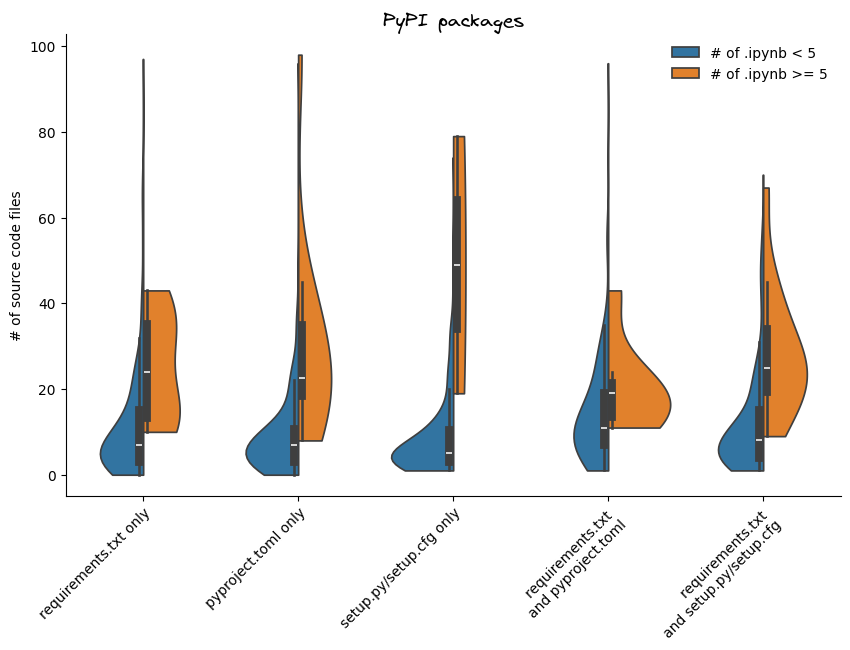

In [126]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=5",
    data=filtered_data_pypi,
    split=True,
    cut=0,
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["# of .ipynb < 5", "# of .ipynb >= 5"], frameon=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "PyPI packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("")
plt.ylabel("# of source code files")
plt.savefig("correlation_pypi_1.png", dpi=600, bbox_inches="tight")

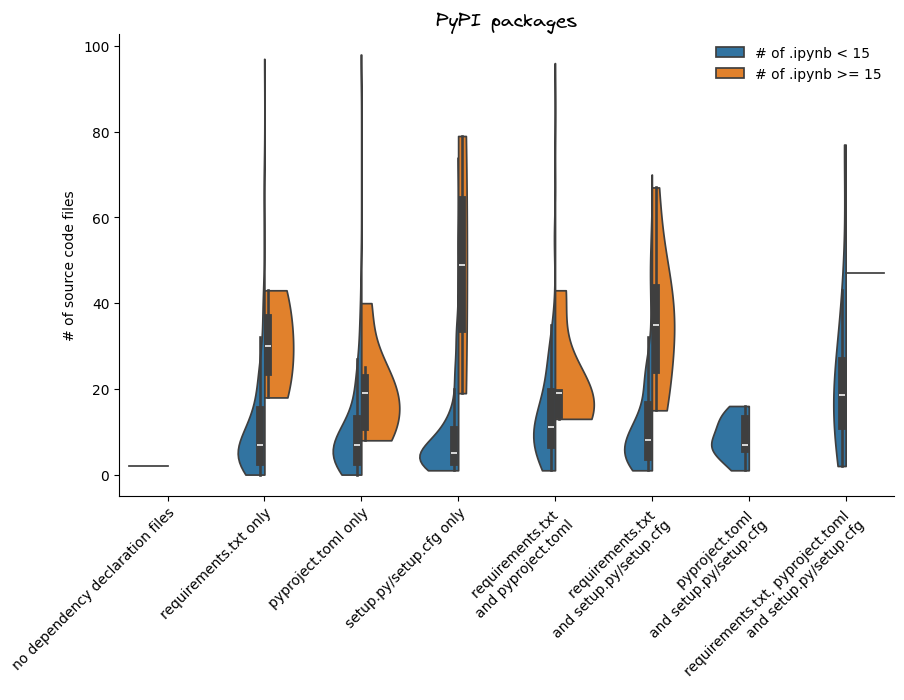

In [49]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=15",
    data=codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100],
    split=True,
    cut=0,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["# of .ipynb < 15", "# of .ipynb >= 15"], frameon=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "PyPI packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("")
plt.ylabel("# of source code files")
plt.savefig("correlation_pypi_2.png", dpi=600, bbox_inches="tight")

In [50]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi[0] == "."]

,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
schedule,.,requirements.txt only,2.0,0.0,False,False,False,False
thinc,.,requirements.txt only,2.0,0.0,False,False,False,False
aiodns,.,setup.py/setup.cfg only,3.0,0.0,False,False,False,False
hstspreload,.,NaN,4.0,0.0,False,False,False,False
snuggs,.,setup.py/setup.cfg only,2.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...
imagesize_py,.,NaN,2.0,0.0,False,False,False,False
schema,.,requirements.txt only,3.0,0.0,False,False,False,False
appdirs,.,NaN,2.0,0.0,False,False,False,False
python-json-pointer,.,requirements.txt only,3.0,0.0,False,False,False,False


In [51]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt only"][
    codedirs_sum_main_pypi[".ipynb count"] >= 5
]

/tmp/ipykernel_8264/2367564508.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt only"][


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
pynndescent,PROJECT_NAME,requirements.txt only,10.0,6.0,True,True,False,False
great_expectations,contrib/great_expectations_semantic_types_expe...,requirements.txt only,115.0,30.0,True,True,True,True
statsmodels,statsmodels/stats,requirements.txt only,43.0,77.0,True,True,True,True
tensorboard,PROJECT_NAME,requirements.txt only,34.0,11.0,True,True,True,False
arviz,arviz/plots,requirements.txt only,30.0,19.0,True,True,True,True
papermill,PROJECT_NAME,requirements.txt only,18.0,28.0,True,True,True,True
umap,PROJECT_NAME,requirements.txt only,11.0,10.0,True,True,True,False
io,tensorflow_io/python/ops,requirements.txt only,39.0,14.0,True,True,True,False
pyramid,pmdarima/datasets,requirements.txt only,14.0,5.0,True,True,False,False


In [52]:
codedirs_sum_main_pypi[
    codedirs_sum_main_pypi["deps"] == "requirements.txt and pyproject.toml"
][codedirs_sum_main_pypi[".ipynb count"] >= 5]

/tmp/ipykernel_8264/944563753.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15


In [53]:
codedirs_sum_main_pypi[
    codedirs_sum_main_pypi["deps"] == "requirements.txt and setup.py/setup.cfg"
][codedirs_sum_main_pypi[".ipynb count"] >= 5]

/tmp/ipykernel_8264/3557192387.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15


In [54]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi[0] == "."].index

Index(['schedule', 'thinc', 'aiodns', 'hstspreload', 'snuggs', 'thefuzz',
       'inflection', 'injector', 'python-decouple', 'python-zstandard',
       ...
       'fastText', 'netifaces', 'pytest-forked', 'lru-dict',
       'python-json-patch', 'imagesize_py', 'schema', 'appdirs',
       'python-json-pointer', 'python-editor'],
      dtype='object', length=130)